In [23]:
from ActivePyTools.grab_data import eval_object_columns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import cv2
import pandas as pd
import numpy as np
import chardet
from joblib import dump, load

crop_path = './docs/crop_pics/google/'

project_root = '../'

def grab_df_data(df_path):
    with open(df_path, 'rb') as file:
        encoding = chardet.detect(file.read())['encoding']

    temp_df = pd.read_csv(df_path, encoding=encoding)
    df = eval_object_columns(temp_df)
    return df

def normalize_row(row, img_shape):
    img_height, img_width, _ = img_shape
    text_len = len(row.txt)
    slope1, slope2, slope3, slope4 = row.slopes
    direction = 1 if row.direction == 'vertical' else 0
    if direction:
        slope = (slope1 + slope3) / 2
    else:
        slope = (slope2 + slope4) / 2
    if slope == 0:
        slope = 0.0001
    angle = np.rad2deg(np.arctan2(abs(slope), 1))
    font_h = row.font * np.sin(angle)
    font_w = row.font * np.cos(angle)
    word_len_h = row.word_len * np.sin(90 - angle)
    word_len_w = row.word_len * np.cos(90 - angle)

    font_h /= img_height
    font_w /= img_width
    word_len_h /= img_height
    word_len_w /= img_width

    font = np.sqrt(font_h**2 + font_w**2)
    word_len = np.sqrt(word_len_h**2 + word_len_w**2)

    center_x, center_y = row.center_point
    center_x /= img_width
    center_y /= img_height
    

    return pd.Series({
        'idx': row.idx,
        'txt_len': text_len,
        'direction': direction,
        'angle': angle,
        'norm_font': font,
        'norm_word_len': word_len,
        'norm_center_x': center_x,
        'norm_center_y': center_y
    })

def sqrt_sq_cbrt_cb(number):
    sign = 1 if number >=0 else -1
    number = abs(number)
    # print(number)
    return sign*np.sqrt(number), np.square(number), sign*np.cbrt(number), sign*np.power(number, 3)

def row_feature_eng(row):
    font_sqrt, font_square, font_cbrt, font_cube = sqrt_sq_cbrt_cb(row.norm_font)
    word_len_sqrt, word_len_square, word_len_cbrt, word_len_cube = sqrt_sq_cbrt_cb(row.txt_len)
    row['font_sqrt'] = font_sqrt
    row['font_square'] = font_square
    row['font_cbrt'] = font_cbrt
    row['font_cube'] = font_cube
    row['word_len_sqrt'] = word_len_sqrt
    row['word_len_square'] = word_len_square
    row['word_len_cbrt'] = word_len_cbrt
    row['word_len_cube'] = word_len_cube
    
    return row

def get_picture_path(relative_path):
    return project_root + relative_path

def normalize_df(df, is_cross_valid = False):

    norm_data = []

    for index, row in df.iterrows():
        img_path = row.img_path
        img = cv2.imread(get_picture_path(img_path))
        if img is not None:
            new_row = normalize_row(row, img.shape)
            if not is_cross_valid:
                label = row.Label
                new_row['label'] = label
            norm_data.append(new_row)
    if is_cross_valid:
        return pd.DataFrame(norm_data, columns=['idx', 'txt_len', 'direction', 'angle', 'norm_font', 'norm_word_len', 'norm_center_x', 'norm_center_y'])
    else:
        return pd.DataFrame(norm_data, columns=['idx', 'label', 'txt_len', 'direction', 'angle', 'norm_font', 'norm_word_len', 'norm_center_x', 'norm_center_y'])

def text_to_vector(text, model):
    # Tokenize the text
    words = text.split()
    # Filter words to make sure they are in the model
    words = [word for word in words if word in model.key_to_index]

    # If no words in the model, return a zero vector
    if len(words) == 0:
        return np.zeros(model.vector_size)

    # Compute average vector
    word_vectors = np.array([model[word] for word in words])
    average_vector = word_vectors.mean(axis=0)
    return average_vector

## Combine Dataframes

In [2]:
df_path1 = '../data/Bookshelves_1_df.csv'
df1 = grab_df_data(df_path1)
df1['img_path'] = df1['crop_idx'].apply(lambda x: f"{crop_path}Bookshelves_1.jpg_{x[0]}_{x[1]}.jpg")
df1['idx'] = df1.index

df_path2 = '../data/Bookshelves_4_df.csv'
df2 = grab_df_data(df_path2)
df2['img_path'] = df2['crop_idx'].apply(lambda x: f"{crop_path}Bookshelves_4.jpg_{x[0]}_{x[1]}.jpg")
df2['idx'] = df1['idx'].max() + df2.index

df_path3 = '../data/IMG_7940_labelled_df.csv'
df3 = grab_df_data(df_path3)
df3['img_path'] = df3['crop_idx'].apply(lambda x: f"{crop_path}IMG_7940.jpeg_{x[0]}_{x[1]}.jpg")
df3['idx'] = df2['idx'].max() + df3.index

In [3]:
df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.drop(columns=['confidence', 'crop_idx', 'Left', 'Top'])
df

,txt,vertices,boundBox,slopes,font,word_len,direction,center_point,Label,img_path,idx
0,THE,"[(83, 360), (85, 402), (69, 403), (67, 361)]","{'Width': 18, 'Height': 43, 'Left': 67, 'Top':...","(-21.0, 0.062, -21.0, 0.062)",16.031220,42.047592,vertical,"(76.0, 381.5)",1,./docs/crop_pics/google/Bookshelves_1.jpg_0_0.jpg,0
1,TIPPING,"[(85, 412), (88, 501), (72, 502), (69, 413)]","{'Width': 19, 'Height': 90, 'Left': 69, 'Top':...","(-29.667, 0.062, -29.667, 0.062)",16.031220,89.050547,vertical,"(78.5, 457.0)",1,./docs/crop_pics/google/Bookshelves_1.jpg_0_0.jpg,1
2,POINT,"[(89, 511), (92, 578), (76, 579), (73, 512)]","{'Width': 19, 'Height': 68, 'Left': 73, 'Top':...","(-22.333, 0.062, -22.333, 0.062)",16.031220,67.067131,vertical,"(82.5, 545.0)",1,./docs/crop_pics/google/Bookshelves_1.jpg_0_0.jpg,2
3,MALCOLM,"[(90, 621), (95, 722), (80, 723), (75, 622)]","{'Width': 20, 'Height': 102, 'Left': 75, 'Top'...","(-20.2, 0.067, -20.2, 0.067)",15.033296,101.123687,vertical,"(85.0, 672.0)",1,./docs/crop_pics/google/Bookshelves_1.jpg_0_0.jpg,3
4,GLADWELL,"[(96, 735), (102, 846), (87, 847), (81, 736)]","{'Width': 21, 'Height': 112, 'Left': 81, 'Top'...","(-18.5, 0.067, -18.5, 0.067)",15.033296,111.162044,vertical,"(91.5, 791.0)",1,./docs/crop_pics/google/Bookshelves_1.jpg_0_0.jpg,4
...,...,...,...,...,...,...,...,...,...,...,...
1415,POETRY,"[(3870, 560), (3858, 639), (3839, 636), (3851,...","{'Width': 31, 'Height': 82, 'Left': 3839, 'Top...","(6.583, -0.158, 6.583, -0.158)",19.235384,79.906195,vertical,"(3854.5, 598.0)",1,./docs/crop_pics/google/IMG_7940.jpeg_0_0.jpg,1413
1416,OF,"[(3877, 517), (3873, 544), (3853, 541), (3857,...","{'Width': 24, 'Height': 30, 'Left': 3853, 'Top...","(6.75, -0.15, 6.75, -0.15)",20.223748,27.294688,vertical,"(3865.0, 529.0)",1,./docs/crop_pics/google/IMG_7940.jpeg_0_0.jpg,1414
1417,BOOK,"[(3887, 451), (3879, 504), (3860, 502), (3868,...","{'Width': 27, 'Height': 56, 'Left': 3860, 'Top...","(6.625, -0.105, 6.75, -0.158)",19.170179,54.094875,vertical,"(3873.5, 476.25)",1,./docs/crop_pics/google/IMG_7940.jpeg_0_0.jpg,1415
1418,THE,"[(3896, 395), (3890, 436), (3870, 433), (3876,...","{'Width': 26, 'Height': 44, 'Left': 3870, 'Top...","(6.833, -0.15, 6.833, -0.15)",20.223748,41.436699,vertical,"(3883.0, 414.0)",1,./docs/crop_pics/google/IMG_7940.jpeg_0_0.jpg,1416


## Prepare Train, Validation, Test Data

In [4]:
one_df = df[df['Label'] == 1]
zero_df = df[df['Label'] == 0]

In [5]:
one_df.shape, zero_df.shape

((1101, 11), (319, 11))

In [ ]:
from sklearn.model_selection import train_test_split

train_one_df, temp_one_df = train_test_split(one_df, test_size=0.4, random_state=42)
valid_one_df, test_one_df = train_test_split(temp_one_df, test_size=0.5, random_state=42)
train_zero_df, temp_zero_df = train_test_split(zero_df, test_size=0.4, random_state=42)
valid_zero_df, test_zero_df = train_test_split(temp_zero_df, test_size=0.5, random_state=42)

In [7]:
rate = train_one_df.shape[0]/train_zero_df.shape[0]
df_duplicated = train_zero_df.copy()
for i in range(int(rate)-1):
    df_duplicated = pd.concat([train_zero_df, df_duplicated], ignore_index=True)

selected_rows = train_zero_df.sample(frac=rate % 1, random_state=42)
resample_train_zero_df = pd.concat([df_duplicated, selected_rows], ignore_index=True)

In [10]:
test_concatenated = pd.concat([test_one_df, test_zero_df], ignore_index=True)
test_df = test_concatenated.sample(frac=1, random_state=42).reset_index(drop=True)
test_df['type'] = 'test'
train_concatenated = pd.concat([train_one_df, resample_train_zero_df], ignore_index=True)
train_df = train_concatenated.sample(frac=1, random_state=42).reset_index(drop=True)
train_df['type'] = 'train'
valid_concatenated = pd.concat([valid_one_df, valid_zero_df], ignore_index=True)
valid_df = valid_concatenated.sample(frac=1, random_state=42).reset_index(drop=True)
valid_df['type'] = 'valid'

In [11]:
loc_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
loc_df.to_csv("../data/split_df.csv", index=False, encoding='utf-8')

### Prepare Location Normalized Data

In [28]:
def preprocess_df(df, scaler):
    norm_df = normalize_df(df)
    norm_df['idx'] = norm_df['idx'].astype(int)
    norm_df['txt_len'] = scaler.transform(norm_df[['txt_len']])
    norm_df = norm_df.apply(row_feature_eng, axis=1)

    return norm_df

                    idx   txt_len  direction     angle  norm_font  \
idx            1.000000  0.032832  -0.464815 -0.002766  -0.212899   
txt_len        0.032832  1.000000  -0.011267  0.023884  -0.058580   
direction     -0.464815 -0.011267   1.000000 -0.196827   0.344612   
angle         -0.002766  0.023884  -0.196827  1.000000  -0.151389   
norm_font     -0.212899 -0.058580   0.344612 -0.151389   1.000000   
norm_word_len -0.169521  0.458119   0.292167 -0.176659   0.592977   
norm_center_x  0.151497 -0.046100  -0.069950 -0.074528  -0.030026   
norm_center_y -0.006257 -0.113302  -0.228474  0.097196  -0.214788   
Label         -0.113693  0.230164   0.521621 -0.006135   0.194715   

               norm_word_len  norm_center_x  norm_center_y     Label  
idx                -0.169521       0.151497      -0.006257 -0.113693  
txt_len             0.458119      -0.046100      -0.113302  0.230164  
direction           0.292167      -0.069950      -0.228474  0.521621  
angle              -0.176

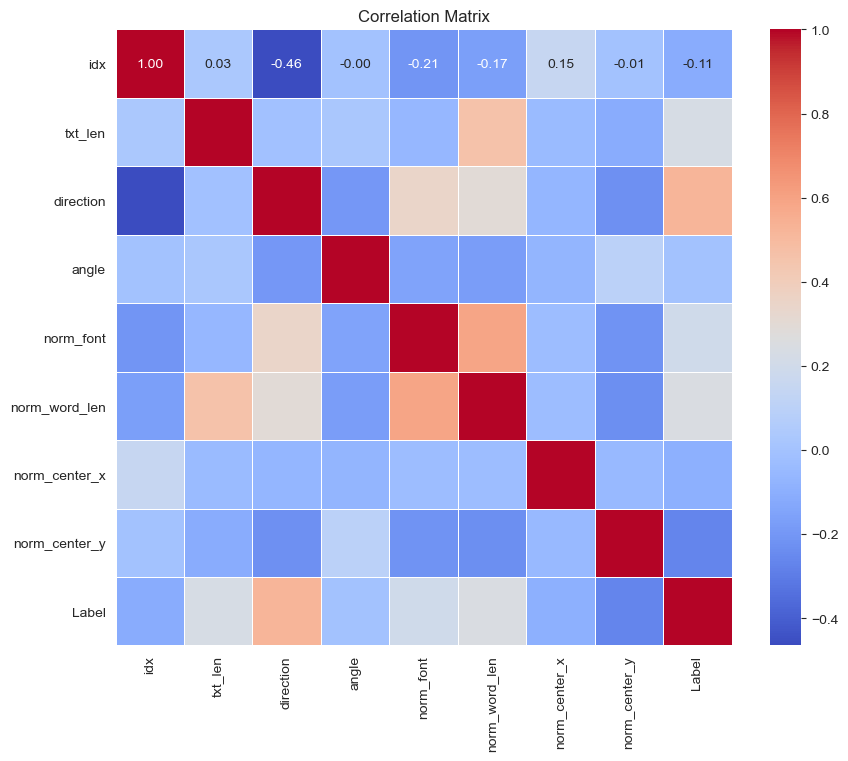

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = loc_df.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

### Prepare Text Vector Normalized Data

In [35]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

In [38]:
def calc_text_vector(df, is_cross_valid=False):
    vector_df = pd.DataFrame()
    if not is_cross_valid:
        vector_df['type'] = df['type']
        vector_df['label'] = df['Label']
    vector_df['txt_vector'] = df['txt'].apply(lambda x: text_to_vector(x, model))
    vector_df['idx'] = df['idx']
    vectors = pd.DataFrame(vector_df['txt_vector'].tolist(), index=vector_df.index)
    vectors.columns = [f'vector_{i}' for i in range(vectors.shape[1])]
    vector_lst_df = pd.concat([vector_df.drop('txt_vector', axis=1), vectors], axis=1)
    
    return vector_lst_df

In [39]:
norm_vec_train_df = calc_text_vector(train_df)
norm_vec_test_df = calc_text_vector(test_df)
norm_vec_valid_df = calc_text_vector(valid_df)

In [33]:
vec_df = pd.concat([norm_vec_train_df, norm_vec_test_df, norm_vec_valid_df], ignore_index=True)
vec_df.to_csv("../data/digit_data/vec_df.csv", index=False, encoding='utf-8')

## Prepare Cross Validation Data

### Split Data

In [ ]:
train_one_df, test_one_df = train_test_split(one_df, test_size=0.2, random_state=42)
train_zero_df, test_zero_df = train_test_split(zero_df, test_size=0.2, random_state=42)

In [ ]:
rate = train_one_df.shape[0]/train_zero_df.shape[0]
df_duplicated = train_zero_df.copy()
for i in range(int(rate)-1):
    df_duplicated = pd.concat([train_zero_df, df_duplicated], ignore_index=True)

selected_rows = train_zero_df.sample(frac=rate % 1, random_state=42)
resample_train_zero_df = pd.concat([df_duplicated, selected_rows], ignore_index=True)

In [ ]:
test_concatenated = pd.concat([test_one_df, test_zero_df], ignore_index=True)
test_df = test_concatenated.sample(frac=1, random_state=42).reset_index(drop=True)

train_concatenated = pd.concat([train_one_df, resample_train_zero_df], ignore_index=True)
train_df = train_concatenated.sample(frac=1, random_state=42).reset_index(drop=True)

### Store Test Data

In [ ]:
test_df.to_csv("../data/cross_valid/test_df.csv", index=False, encoding='utf-8')

### Store Train and Validation Data

In [ ]:
from sklearn.model_selection import StratifiedKFold

X = train_df.drop(columns=['Label'])
y = train_df['Label']

skf = StratifiedKFold(n_splits=5)
counter = 0
for train_idx, valid_idx in skf.split(X, y):
    counter += 1
    x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    folder = '../data/cross_valid/k' + str(counter) + '/'

    x_train.to_csv(folder + 'x_train.csv', index=False, encoding='utf-8')
    x_valid.to_csv(folder + 'x_valid.csv', index=False, encoding='utf-8')
    y_train.to_csv(folder + 'y_train.csv', index=False, encoding='utf-8')
    y_valid.to_csv(folder + 'y_valid.csv', index=False, encoding='utf-8')

### Prepare Location Normalized Data

In [ ]:
norm_df = normalize_df(X, True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(norm_df[['txt_len']])

for i in range(1, 6):
    folder = '../data/cross_valid/k' + str(i) + '/'
    x_train = grab_df_data(folder + 'x_train.csv')
    x_valid = grab_df_data(folder + 'x_valid.csv')
    y_train = grab_df_data(folder + 'y_train.csv')
    y_valid = grab_df_data(folder + 'y_valid.csv')

    norm_loc_x_train = preprocess_df(x_train, scaler)
    norm_loc_x_valid = preprocess_df(x_valid, scaler)

    norm_loc_x_train.to_csv(folder + 'loc_x_train.csv', index=False, encoding='utf-8')
    norm_loc_x_valid.to_csv(folder + 'loc_x_valid.csv', index=False, encoding='utf-8')

dump(scaler, './min_max_scaler.joblib')

### Prepare Text Vector Normalized Data

In [ ]:
for i in range(1, 6):
    folder = '../data/cross_valid/k' + str(i) + '/'
    x_train = grab_df_data(folder + 'x_train.csv')
    x_valid = grab_df_data(folder + 'x_valid.csv')
    y_train = grab_df_data(folder + 'y_train.csv')
    y_valid = grab_df_data(folder + 'y_valid.csv')

    norm_vec_x_train = calc_text_vector(x_train)
    norm_vec_x_valid = calc_text_vector(x_valid)

    norm_vec_x_train.to_csv(folder + 'vec_x_train.csv', index=False, encoding='utf-8')
    norm_vec_x_valid.to_csv(folder + 'vec_x_valid.csv', index=False, encoding='utf-8')

### Prepare Test Location and Vector Data

In [40]:
x_test = test_df.drop(columns=['Label'])
y_test = test_df['Label']

norm_loc_x_test = preprocess_df(x_test, scaler)
norm_vec_x_test = calc_text_vector(x_test)

y_test.to_csv('../data/cross_valid/y_test.csv', index=False, encoding='utf-8')
norm_loc_x_test.to_csv('../data/cross_valid/loc_x_test.csv', index=False, encoding='utf-8')
norm_vec_x_test.to_csv('../data/cross_valid/vec_x_test.csv', index=False, encoding='utf-8')